<div style="background-color:#1e1e1e; color:#f0f0f0; padding:12px; border-radius:8px; line-height:1.5; font-size:16px;">

<h2 style="margin-top:0; color:#ffffff;">Options</h2>

The goal of this notebook is to explore several options strategies. To do so, we use both 
<span style="color:#7CFC00;"><b>yahoo finance (yfinance)</b></span> and 
<span style="color:#00CED1;"><b>polygon.io</b></span> data.<br><br>

We lean mostly on the polygon data, which means that each user of this notebook will have to create and store a 
<span style="color:#00CED1;"><b>polygon API key</b></span> somewhere on their local machine.<br><br>

<b style="color:#FF6F61;">Note:</b> The polygon API key that I 
<span style="color:#DA70D6;"><b>(Mike Kovacevich)</b></span> have used to gather the data below corresponds to one of Polygon's paid tiers 
(I think it is $30 a month or something). The goal was to get access to options contracts and be able to analyze them via the "Greeks" and Implied Volatility

</div>


In [1]:
#Install any necessary packages here rather than the command line
!uv pip install dotenv
!uv pip install polygon-api-client
!uv pip install mplfinance

Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 1 package in 42ms
Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 1 package in 7ms
Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 1 package in 28ms


In [2]:
import os
import requests
from dotenv import load_dotenv
from datetime import date, datetime, timedelta
from datetime import timezone as dt_timezone
from dateutil.relativedelta import relativedelta
import mplfinance as mpf
import numpy as np
import pandas as pd

#Retrieve the API key from another directory that is NOT uploaded to Github
load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")

Below we create functions that load options contracts for a given stock ticker (e.g AAPL, AAL, etc). We look at a specific date range of contracts since we want to analyze mediumish term contracts

In [3]:
def analyze_option_contract(underlying: str, option_ticker: str, api_key: str):
    """Fetch and display Greeks and IV for a specific option contract."""
    url = f"https://api.polygon.io/v3/snapshot/options/{underlying}/{option_ticker}?apiKey={api_key}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"[WARN] Could not fetch option {option_ticker}: {e}")
        return None

    data = response.json()
    results = data.get("results", {})
    if not results:
        print(f"[WARN] No results for option {option_ticker}")
        return None

    greeks = results.get("greeks", {})
    implied_volatility = results.get("implied_volatility")

    print("\nOption Details:")
    print(f"Ticker: {option_ticker}")
    print(f"Delta: {greeks.get('delta')}")
    print(f"Gamma: {greeks.get('gamma')}")
    print(f"Theta: {greeks.get('theta')}")
    print(f"Vega: {greeks.get('vega')}")
    print(f"Implied Volatility: {implied_volatility}")

    return results

def get_current_stock_price(ticker: str) -> float:
    """Fetch current stock price from Polygon."""
    url = f"https://api.polygon.io/v2/last/trade/{ticker}?apiKey={API_KEY}"
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.json()["last"]["price"]

def get_option_contracts(ticker: str, limit: int = 1000, min_days: int = 20, max_days: int = 120):
    """Fetch option contracts for a given ticker within a specified expiration range."""
    base_url = "https://api.polygon.io/v3/reference/options/contracts"
    params = {
        "underlying_ticker": ticker,
        "limit": limit,
        "apiKey": API_KEY
    }

    today = datetime.now(dt_timezone.utc).date()
    min_exp = today + timedelta(days=min_days)
    max_exp = today + timedelta(days=max_days)

    contracts = []
    url = base_url

    while url:
        response = requests.get(url, params=params)
        data = response.json()

        if not data.get("results"):
            break

        for c in data["results"]:
            exp_date = datetime.strptime(c["expiration_date"], "%Y-%m-%d").date()
            if min_exp <= exp_date <= max_exp:
                try:
                    greeks_data = analyze_option_contract(ticker, c["ticker"], API_KEY)
                    if greeks_data:
                        c["greeks"] = greeks_data
                        contracts.append(c)
                except Exception as e:
                    print(f"[WARN] Skipping {c['ticker']} due to error: {e}")
                    continue

        url = data.get("next_url")
        params = {}  # Only needed for the first request

    return contracts

def print_options_contracts(contracts):
    if not contracts:
        print("No option contracts to display.")
        return

    print(f"{'Index':<6} {'Ticker':<25} {'Strike':<10} {'Type':<6} {'Style':<10} {'Expires':<12} {'Exchange'}")
    print("-" * 100)
    for idx, c in enumerate(contracts):
        print(f"{idx:<6} {c['ticker']:<25} {c['strike_price']:<10} {c['contract_type']:<6} {c['exercise_style']:<10} {c['expiration_date']:<12} {c['primary_exchange']}")

def get_latest_closing_price(
    symbol: str,
    from_date: str,
    to_date: str,
    api_key: str,
    multiplier: int = 1,
    timespan: str = "day"
) -> float | None:
    """
    Returns the latest closing price for the given ticker between from_date and to_date.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "desc",   # Sort descending so latest is first
        "limit": 1,       # Only need the latest
        "apiKey": api_key
    }

    res = requests.get(url, params=params)
    data = res.json()

    if "results" in data and data["results"]:
        latest = data["results"][0]
        return latest["c"]  # Closing price
    else:
        print("Error or no data:", data)
        return None


In [4]:
#The code below is more script like rather than a notebook - should be cleaned up
ticker = "VOO"
contracts = get_option_contracts(ticker)


Option Details:
Ticker: O:VOO250905C00470000
Delta: 0.9590012430401842
Gamma: 0.0011329030374619272
Theta: -0.1668037088248698
Vega: 0.13586340055946913
Implied Volatility: 0.49960029877949513

Option Details:
Ticker: O:VOO250905C00475000
Delta: 0.9567029386602725
Gamma: 0.0012290184501837498
Theta: -0.1687079727992956
Vega: 0.13652380910670453
Implied Volatility: 0.4822623973804379

Option Details:
Ticker: O:VOO250905C00480000
Delta: 0.9564849057538157
Gamma: 0.0012999862199717317
Theta: -0.16305563183971486
Vega: 0.13706143071340646
Implied Volatility: 0.45783033734160955

Option Details:
Ticker: O:VOO250905C00485000
Delta: 0.951626130833486
Gamma: 0.0014538245034755625
Theta: -0.17251331690480345
Vega: 0.13783107121439542
Implied Volatility: 0.44817997793538694

Option Details:
Ticker: O:VOO250905C00490000
Delta: 0.9465613418275277
Gamma: 0.0016193302275747618
Theta: -0.1819706967831413
Vega: 0.13860799490045778
Implied Volatility: 0.43864856054595536

Option Details:
Ticker: O:VOO

In [5]:
valid_contracts_idx = [
    i for i, contracts in enumerate(contracts)
    if contracts.get('greeks', {}).get('greeks')
]
valid_contracts = [contracts[i] for i in valid_contracts_idx]

Lets further look at the actual stock movement of a given ticker symbol (continuing with the NVDA trend here)

In [8]:
def get_latest_closing_price(
    symbol: str,
    from_date: str,
    to_date: str,
    api_key: str,
    multiplier: int = 1,
    timespan: str = "day"
) -> float | None:
    """
    Returns the latest closing price for the given ticker between from_date and to_date.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "desc",   # Sort descending so latest is first
        "limit": 1,       # Only need the latest
        "apiKey": api_key
    }

    res = requests.get(url, params=params)
    data = res.json()

    if "results" in data and data["results"]:
        latest = data["results"][0]
        return latest["c"]  # Closing price
    else:
        print("Error or no data:", data)
        return None

today_date = date.today().strftime("%Y-%m-%d")
previous_date = (date.fromisoformat(today_date) - relativedelta(years=2)).isoformat()

price = get_latest_closing_price(ticker, previous_date, today_date, API_KEY)

In [9]:
price

585.74

In [10]:
multiplier = 1
timespan = "day"

url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{previous_date}/{today_date}"
params = {
    "adjusted": "true",
    "sort": "asc",     # or "desc"
    "limit": 00,
    "apiKey": API_KEY
}

res = requests.get(url, params=params)
data = res.json()

# Preview the results
if "results" in data:
    for candle in data["results"]:
        t = datetime.fromtimestamp(candle["t"] / 1000)
        print(f"{t.date()} - O: {candle['o']} H: {candle['h']} L: {candle['l']} C: {candle['c']} V: {candle['v']}")
else:
    print("Error or no data:", data)

2023-08-14 - O: 408.56 H: 411.74 L: 408.31 C: 411.72 V: 2772912.0
2023-08-15 - O: 410.09 H: 411.7125 L: 406.41 C: 407 V: 4686119.0
2023-08-16 - O: 406.59 H: 408.11 L: 403.87 C: 403.99 V: 3353653.0
2023-08-17 - O: 405.33 H: 405.58 L: 400.37 C: 400.72 V: 7102504.0
2023-08-18 - O: 398.17 H: 402.02 L: 397.85 C: 401.09 V: 4157667.0
2023-08-21 - O: 402.14 H: 404.39 L: 399.99 C: 403.74 V: 3292434.0
2023-08-22 - O: 405.35 H: 405.4 L: 402.06 C: 402.61 V: 2648051.0
2023-08-23 - O: 403.56 H: 407.67 L: 403.47 C: 406.95 V: 3249964.0
2023-08-24 - O: 408.6 H: 409.079 L: 401.4 C: 401.54 V: 3458791.0
2023-08-25 - O: 403.08 H: 405.8 L: 399.71 C: 404.2 V: 4417835.0
2023-08-28 - O: 406.36 H: 407.44 L: 405.1 C: 406.86 V: 3236711.0
2023-08-29 - O: 406.78 H: 412.98 L: 406.57 C: 412.64 V: 3482664.0
2023-08-30 - O: 413.03 H: 415.0292 L: 412.4 C: 414.36 V: 3004516.0
2023-08-31 - O: 414.982 H: 416.12 L: 413.66 C: 413.83 V: 4751131.0
2023-09-01 - O: 416.46 H: 416.88 L: 413.21 C: 414.71 V: 3587971.0
2023-09-05 - O

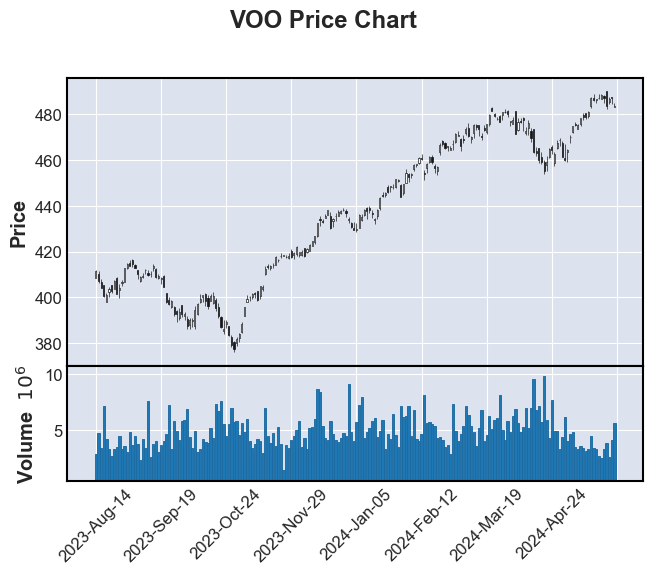

In [13]:
url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{previous_date}/{today_date}"

params = {
    "adjusted": "true",
    "sort": "asc",
    "limit": 200,
    "apiKey": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if "results" not in data:
    print("Error or no results:", data)
else:
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.set_index("t", inplace=True)

    df = df.rename(columns={
        "o": "Open",
        "h": "High",
        "l": "Low",
        "c": "Close",
        "v": "Volume"
    })

    df = df[["Open", "High", "Low", "Close", "Volume"]]

    mpf.plot(df, type="candle", volume=True, title=f"{ticker} Price Chart")


In [14]:
type(data)

dict